# Setup #

In [73]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import PIL
from PIL import Image

import os
import math

# Detection algorithm works with an NxN matrix
N = 32
#N is a power of 2

# Helper Functions #

In [74]:
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [84]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    assert np.sum(np.square(image_norm)) == 1, f"Sum of amplitudes-squared does not equal one. Sum is: {np.sum(image_norm)}"

    # Return the normalized image as a numpy array
    return np.array(image_norm)
    

# Image Preprocessing #

In [85]:
#Input Processing to np array

#img_raw = plt.imread(os.path.join("test_images", "timothycapybara.png"))
img_raw = plt.imread(r"C:\Users\gsuser\Documents\GitHub\Capybaras-Capstone-Project\test_images\squarecapybara.jpg")

n, m, k = img_raw.shape
print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
sz = n // N

Raw Image info: (512, 512, 3)
Raw Image datatype: uint8


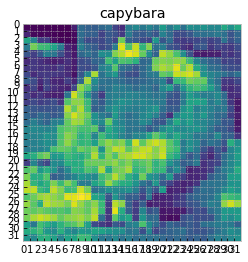

22161.192156862744


In [96]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        val = 0
        #This will be a single cell in final pixel
        for k in range(0, sz):
            val += np.sum(img_raw[i + k][j:j+sz][0]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][1]) / 255
#             val += np.sum(img_raw[i + k][j:j+sz][2]) / 255
            
        img[i//sz][j//sz] = val

plot_image(img, "capybara")

print(np.sum(img))


In [87]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

# Quantum Part (Simulation)

In [88]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

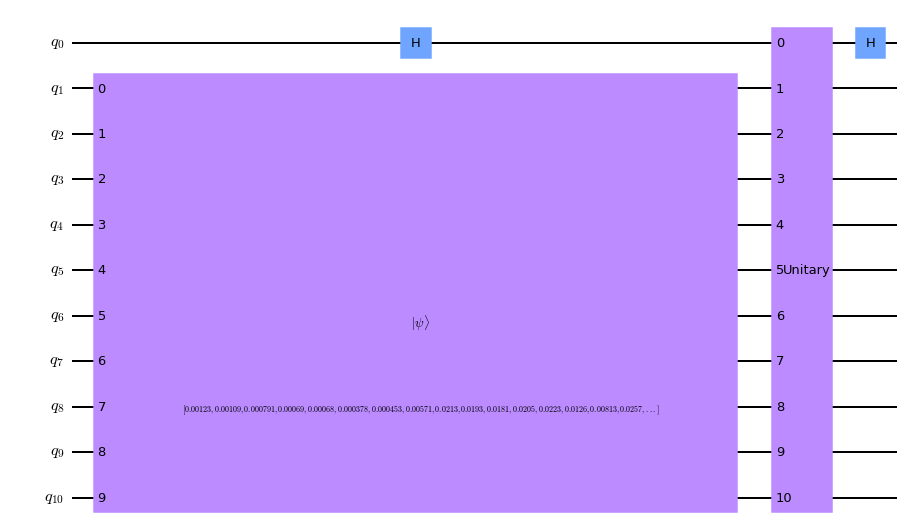

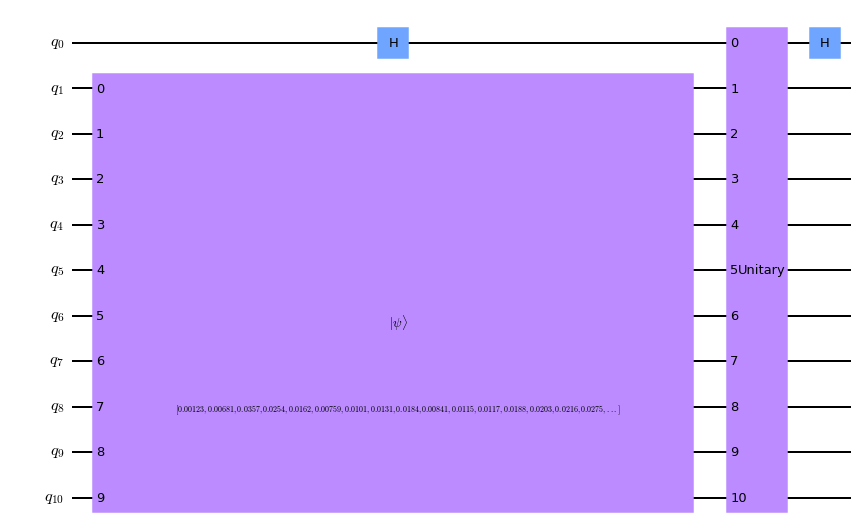

In [89]:
# horizontal scan circuit
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# vertical scan circuit
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits
circ_list = [qc_h, qc_v]

In [90]:
# run simulator
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

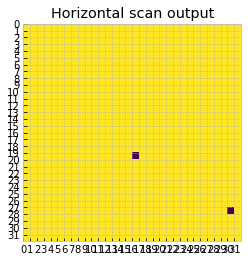

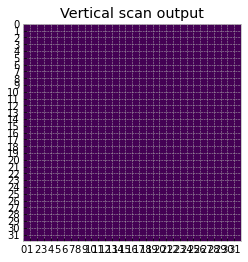

In [91]:
# Classical postprocessing and plotting

# lambda function for binary value thresholding
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# select odd states from raw statevectors and 
# reshape column vector to NxN
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N).T

# plotting horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

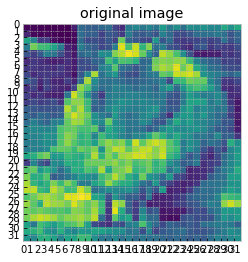

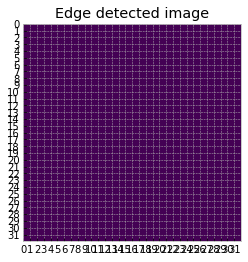

In [92]:
# combining horizontal and vertical
edge_scan_sim = edge_scan_h | edge_scan_v

# plot original and edge detected images
plot_image(img, 'original image')
plot_image(edge_scan_sim, 'Edge detected image')